In [1]:
import h5py
import numpy as np
from scipy.io import readsav

save_h5 = 'Res/results_2016case.h5'
figname = 'Figs/sza_vs_alt_2016case.png'
boundary = 'vignes_empirical_boundaries.save'
# N = 9234250

with h5py.File(save_h5, 'r') as f:
    
    pred = np.sqrt(np.mean(np.array(f['Y_pred_MLP'])**2, axis=1))
    Y = np.sqrt(np.mean(np.array(f['Y'])**2, axis=1))
    X = np.array(f['X'])
    leng = np.array(f['len']).astype(int)

filename = 'Mars.save'
data = readsav(filename)

############## denormalize & retrieve ####################
alt_mean = data['altitude'].flatten().mean()
alt_std = data['altitude'].flatten().std()
altitude = X[:, 11] * alt_std + alt_mean
sza = np.rad2deg(np.arccos(X[:, 10].flatten()))

print('the shape of sza: {}'.format(sza.shape))
print('the shape of altitude: {}'.format(altitude.shape))
print('the shape of pred: {}'.format(pred.shape))
print('the shape of Y: {}'.format(Y.shape))




the shape of sza: (24958,)
the shape of altitude: (24958,)
the shape of pred: (24958,)
the shape of Y: (24958,)


In [ ]:
import numpy as np
import pandas as pd

valid1_filename = 'mvn_orbits_20161002T0749_20161003T0220.save'
valid2_filename = 'mvn_orbits_20161204T2209_20161205T1158.save'

# --- 1. Load Your Data ---

# For demonstration, I'll create sample observational data with the shapes you described.
# In your code, you would already have these arrays loaded.
print("Loading and preparing data...")

data = readsav(filename)

test1 = readsav(valid1_filename)
test2 = readsav(valid2_filename)

sza = np.hstack((test1['mso_sza'].data, test2['mso_sza'].data))
altitude = np.hstack((test1['altitude'].data, test2['altitude'].data))

# Load the empirical boundary model from the file.
# np.load() is the standard way to open .save or .npz files.
vignes_model = readsav('vignes_empirical_boundaries.save')

# Extract the model variables from the loaded dictionary
sza_grid = vignes_model['sza_grid']
alt_mpb = vignes_model['alt_mpb']

print(f"Shape of your SZA data: {sza.shape}")
print(f"Shape of your altitude data: {altitude.shape}")
print(f"Shape of model sza_grid: {sza_grid.shape}")
print(f"Shape of model alt_mpb: {alt_mpb.shape}\n")


# --- 2. Interpolate the Boundary Altitude (The Key Step) ---

# For each point in our 'sza' data, we find the corresponding boundary altitude
# from the vignes_model grid.
print("Interpolating the MPB altitude for each data point...")
mpb_altitude_at_sza = np.interp(sza, sza_grid, alt_mpb)

# The result is a new array, perfectly aligned with your data.
print(f"Shape of the new interpolated MPB altitude array: {mpb_altitude_at_sza.shape}\n")


# --- 3. Identify Points Below the MPB ---

# Now, we can perform a direct, element-wise comparison.
# The result is a boolean array (or "mask").
is_below_mpb = altitude < mpb_altitude_at_sza


# --- 4. Use the Results ---

print("Analyzing the results...")

# a) Count how many points are below the boundary
count_below = np.sum(is_below_mpb)
print(f"Total number of points below the MPB: {count_below} out of {len(sza)}")

# b) Create a descriptive label for each point
# This is great for plotting or further analysis.
location_label = np.where(is_below_mpb, 'Inside MPB', 'Outside MPB')
print("\nFirst 10 location labels:", location_label[:10])

# c) Filter your original data to get only the points below the boundary
# We can put our data into a pandas DataFrame for easy filtering.
df = pd.DataFrame({
    'mso_sza': sza,
    'altitude': altitude,
    'mpb_boundary_alt': mpb_altitude_at_sza, # The interpolated boundary
    'location': location_label
})

df_inside_mpb = df[df['location'] == 'Inside MPB']

print("\nDataFrame containing all data:")
print(df.head())

print("\nDataFrame containing only data points inside the MPB:")
print(df_inside_mpb.head())

Loading and preparing data...


UnpicklingError: Failed to interpret file 'vignes_empirical_boundaries.save' as a pickle

In [20]:
print(test1['mso_sza'].data.shape)
sza = np.hstack((test1['mso_sza'].data, test2['mso_sza'].data))
sza.shape

(12512,)


(24960,)

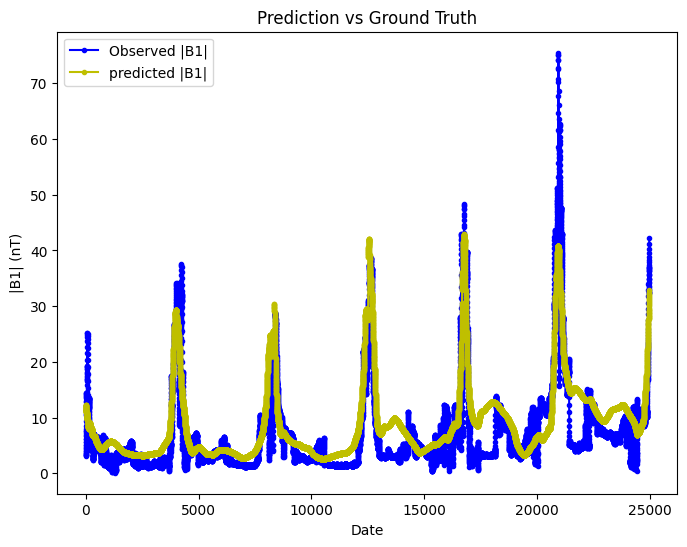

In [12]:
from funs import plot_dual_binned_prediction_contour, plot_prediction_comparison

idx = np.where(altitude<2500)[0]

# plot_dual_binned_prediction_contour(
#     sza = sza, 
#     altitude = altitude, 
#     predict = pred,
#     measure = Y,
#     idx_sel=idx,
#     bins=50,
#     figname = 'Figs/B1_sza_vs_alt.png',
#     )

plot_prediction_comparison(
    pred=pred,
    Y=Y,
    # pred=pred[3500:4500],
    # Y=Y[3500:4500],
    bins=50,
    figname='Figs/B1_pred_vs_true.png'
)

In [11]:
def calculate_correlation(data1, data2):
  """
  Calculates the Pearson correlation coefficient between two datasets.

  Args:
    data1: A list or numpy array representing the first dataset.
    data2: A list or numpy array representing the second dataset.

  Returns:
    The Pearson correlation coefficient between the two datasets.
    Returns None if the datasets are empty or have different lengths.
  """
  return np.corrcoef(data1, data2)[0, 1]

correlation_test1 = calculate_correlation(pred[:leng[0]], Y[:leng[0]])
correlation_test2 = calculate_correlation(pred[leng[0]:], Y[leng[0]:])
print('cc of event1/2 is: {}/{}'.format(correlation_test1, correlation_test2))

cc of event1/2 is: 0.85984666762018/0.8182045138971528


In [5]:
Y.shape

(24958,)